## Statistical Test

From the exploratory analysis, we identify that sales tend to fluctuate by month and day of week, both of which are time-series components. We will access the time-series nature of the data to ensure it follows certain properties since any time-series predictive models will rely on that.

In [1]:
from datetime import datetime as dt
from datetime import date
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from statsmodels.tsa.stattools import acf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARMA, ARIMA
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline 

In [2]:
train_df = pd.read_csv('data/train_df.csv', parse_dates=['date'])

In [3]:
train_df.head()

,date,date_block_num,shop_id,shop_name,item_id,item_name,item_category_id,item_category_name,item_price,item_cnt_day,sales
0,2013-01-02,0,59,"Ярославль ТЦ ""Альтаир""",22154,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,999.0,1.0,999.0
1,2013-01-02,0,25,"Москва ТРК ""Атриум""",22154,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,999.0,1.0,999.0
2,2013-01-03,0,25,"Москва ТРК ""Атриум""",22154,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,999.0,1.0,999.0
3,2013-01-20,0,25,"Москва ТРК ""Атриум""",22154,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,999.0,1.0,999.0
4,2013-01-23,0,25,"Москва ТРК ""Атриум""",22154,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,999.0,1.0,999.0


### Autocorrelation

Test if each day of sales has correlation to daily sales of another day. Resample data to test week and month. Identify lags that has the highest autocorrelation

In [4]:
ts_data = train_df[['date','sales']]

In [5]:
ts_daily = ts_data.groupby(['date'])['sales'].sum()

In [6]:
ts_weekly = ts_daily.resample(rule='W').last()
ts_monthly = ts_daily.resample(rule='M').last()

In [7]:
ts_weekly.index[-15:]

DatetimeIndex(['2015-07-26', '2015-08-02', '2015-08-09', '2015-08-16',
               '2015-08-23', '2015-08-30', '2015-09-06', '2015-09-13',
               '2015-09-20', '2015-09-27', '2015-10-04', '2015-10-11',
               '2015-10-18', '2015-10-25', '2015-11-01'],
              dtype='datetime64[ns]', name='date', freq='W-SUN')

In [8]:
auto_daily = ts_daily.pct_change().autocorr()
auto_weekly = ts_weekly.pct_change().autocorr()
auto_monthly = ts_monthly.pct_change().autocorr()

In [9]:
print('Daily_autocorrelation {}'.format(auto_daily))
print('Weekly_autocorrelation {}'.format(auto_weekly))
print('Monthly_autocorrelation {}'.format(auto_monthly))

Daily_autocorrelation -0.08463005530311793
Weekly_autocorrelation -0.23559041330362235
Monthly_autocorrelation -0.21480875731501684


The daily autocorrelation is almost not exist (~8%). Weekly and monthly has 3 times higher in autocorrelation magnitude. We will focusing on those two frequencies.

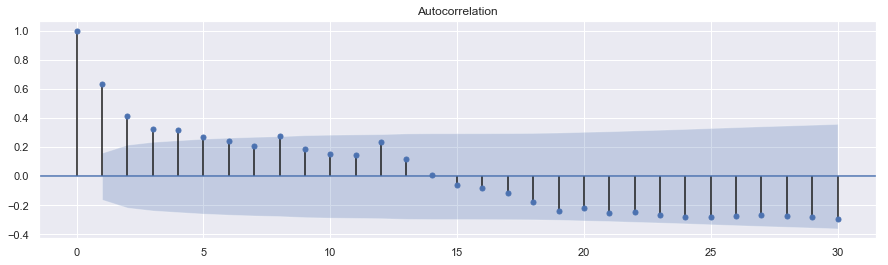

In [10]:
fig, ax = plt.subplots(figsize=(15, 4))
plot_acf(ts_weekly, alpha=.05, ax=ax, lags=30)
plt.show()

Strong lags at 2, 3, and 52

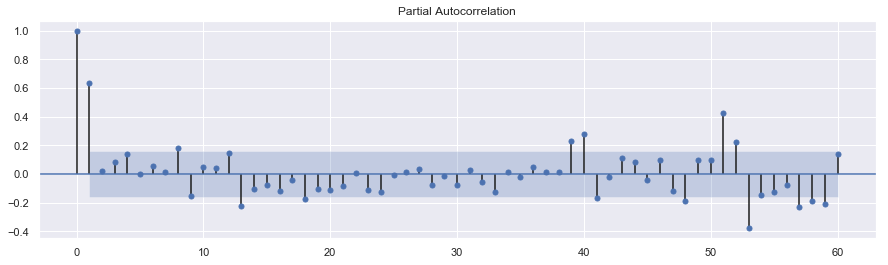

In [11]:
fig1, ax = plt.subplots(figsize=(15, 4))
plot_pacf(ts_weekly, alpha=.05, ax=ax, lags=60)
plt.show()

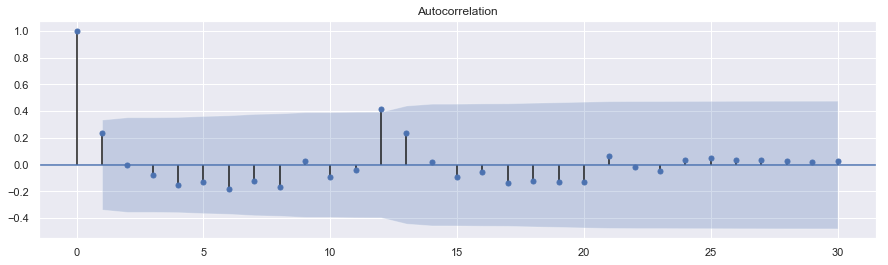

In [12]:
fig2, ax = plt.subplots(figsize=(15, 4))
plot_acf(ts_monthly, alpha=.05, ax=ax, lags=30)
plt.show()

Strong lag at 12

C:\Users\sit_k\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


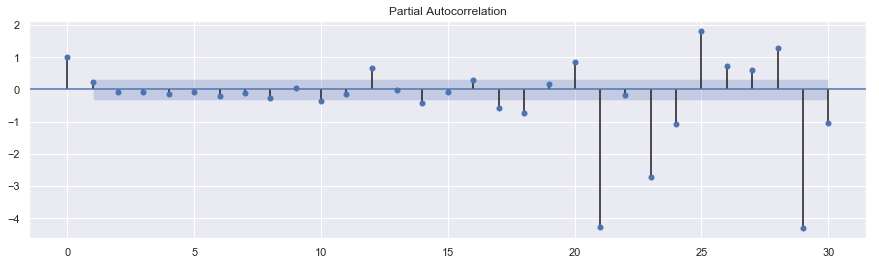

In [13]:
fig3, ax = plt.subplots(figsize=(15, 4))
plot_pacf(ts_monthly, alpha=.05, ax=ax, lags=30)
plt.show()

Weekly level appears to give us more information on the lag, we will focus on weekly time series data from now on. We also want to check the confident intervals on the autocorrelation.

In [14]:
conf = 1.96/np.sqrt(len(ts_weekly))
print("The approximate confidence interval is +/- %4.2f" %(conf))

The approximate confidence interval is +/- 0.16


### Random Walk Test

**H0**: data follow patten of random walk
<br>
**H1**: data does not follow pattern of random walk

Apply Dickey-Fuller test

In [15]:
results =adfuller(ts_weekly)
print(results)
print('p-value is {:.4%}'.format(results[1]))

(-5.704656865380627, 7.536734912512145e-07, 0, 147, {'1%': -3.4756368462466662, '5%': -2.8814104466172608, '10%': -2.5773652982553568}, 4141.481596579406)
p-value is 0.0001%


We will reject H0 that the data follow random walk pattern.

### Seasonality Adjustments

We want to identify and remove the seasonal component from the data for later modeling purposes. From the autocorrelation analysis, we identify 2, 3, and 52 to be strong lags. We choose 52 because 2 and 3 significance disappear if we observed at the monthly level.

In [16]:
ts_weeklysa = ts_weekly.diff(periods=52)

In [17]:
ts_weeklysa = ts_weeklysa.dropna()

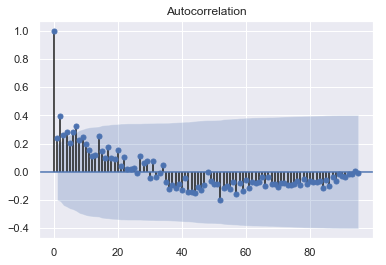

In [18]:
plot_acf(ts_weeklysa, alpha=.05)
plt.show()

## Modeling

### Simple ARMA model

We will start with model order 1 to get a naive based model predictions on sales. We split the dataset into train (Jan 2013 - Jul 2015) and test (Aug 2015 - Oct 2015).

In [19]:
ts_train = ts_weekly.loc[:'2015-07-26']
ts_test = ts_weekly.loc['2015-08-02':]

In [20]:
mod = ARMA(ts_train, order=(1,0))
res = mod.fit()
prediction = res.predict(start='2015-08-02', end='2015-11-01')

C:\Users\sit_k\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


In [21]:
comparsion = pd.DataFrame({'predict': prediction, 'test': ts_test})

In [22]:
print('RMSE is {:,.0f}'.format(mean_squared_error(ts_test, prediction)))

RMSE is 885,162,372,129


Above is the 1st order model result. We will find the optimal order(s) that will lead to the minimal BIC

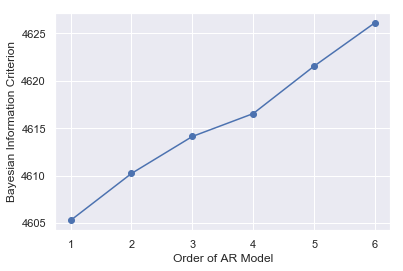

In [23]:
BIC = np.zeros(7)
for p in range(7):
    mod = ARMA(ts_weekly, order=(p,0))
    res = mod.fit()
# Save BIC for AR(p)    
    BIC[p] = res.bic
    
# Plot the BIC as a function of p
plt.plot(range(1,7), BIC[1:7], marker='o')
plt.xlabel('Order of AR Model')
plt.ylabel('Bayesian Information Criterion')
plt.show()

AR = 1 is the best parameter. We repeat the same process for finding MA, with AR already set at 1

Using trial and error, it turns out MA=2 will result in the lowest RSME

In [24]:
mod_1 = ARMA(ts_train, order=(1,2))
res_1 = mod_1.fit()
prediction_1 = res_1.predict(start='2015-08-02', end='2015-11-01')
print('RMSE is {:,.0f}'.format(mean_squared_error(ts_test, prediction_1)))

RMSE is 570,733,030,280


C:\Users\sit_k\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


RSME dropped by 35% when MA order is added to the model

In [25]:
res_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  sales   No. Observations:                  134
Model:                     ARMA(1, 2)   Log Likelihood               -2082.008
Method:                       css-mle   S.D. of innovations        1351076.077
Date:                Sun, 26 Jan 2020   AIC                           4174.015
Time:                        18:33:35   BIC                           4188.505
Sample:                    01-06-2013   HQIC                          4179.903
                         - 07-26-2015                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        3.596e+06   3.94e+05      9.134      0.000    2.82e+06    4.37e+06
ar.L1.sales     0.8388      0.122      6.896      0.000       0.600       1.077
ma.L1.sales    -0.2608      0.168     -1.552      0.123      -0.590       0.069
ma.L2.sales    -0.1797      0.124     -1.444      0.151      -0.424       0.064
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1921           +0.0000j            1.1921            0.0000
MA.1            1.7422           +0.0000j            1.7422            0.0000
MA.2           -3.1934           +0.0000j            3.1934            0.5000
-----------------------------------------------------------------------------
"""

Final step is to integrate the ARMA into ARIMA

In [26]:
mod_2 = ARIMA(ts_weekly, order=(1,0,2))
res_2 = mod_2.fit()
prediction_2 = res_2.predict(start='2015-08-02', end='2015-11-01')
print('RMSE is {:,.0f}'.format(mean_squared_error(ts_test, prediction_2)))

RMSE is 427,336,678,809


In [27]:
comparsion = pd.DataFrame({'predict': prediction, 'predict_1': prediction_1, 'predict_2': prediction_2, 'test': ts_test})

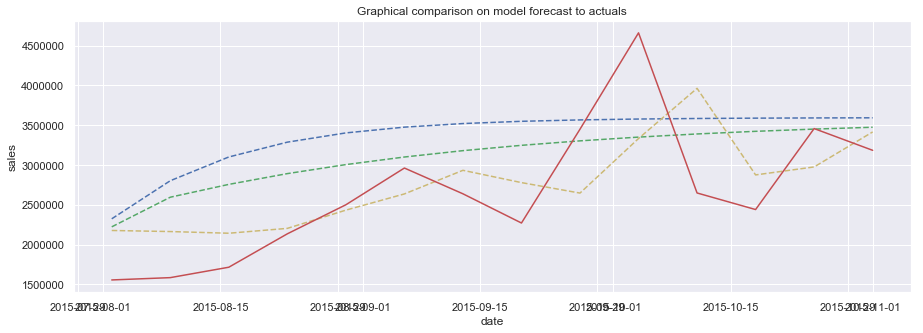

In [28]:
plt.figure(figsize=(15,5))
plt.plot(comparsion['predict'], color='b', linestyle='dashed')
plt.plot(comparsion['predict_1'], color='g', linestyle='dashed')
plt.plot(comparsion['predict_2'], color='y', linestyle='dashed')
plt.plot(comparsion['test'], color='r')
plt.title('Graphical comparison on model forecast to actuals')
plt.xlabel('date')
plt.ylabel('sales')
plt.show()

#### Model Comparison

In [29]:
model = pd.DataFrame({'model': ['AR', 'ARMA', 'ARIMA'], 
                      'RMSE': [mean_squared_error(ts_test, prediction), mean_squared_error(ts_test, prediction_1), mean_squared_error(ts_test, prediction_2)],
                     'AIC+BIC':[(res.aic+res.bic), (res_1.aic+res_1.bic), (res_2.aic+res_2.bic)]})

In [30]:
model.set_index('model')

,RMSE,AIC+BIC
model,,
AR,8.851624e+11,9228.236325
ARMA,5.707330e+11,8362.519812
ARIMA,4.273367e+11,9210.790978


### Observations

ARIMA has the smallest RMSE among the 3 models but AIC+BIC is the largest, which pose risks on overfitting. ARMA has higher RMSE (but still lower than AR model) while keeping the same level of AIC+BIC.

### Next Steps

While ARIMA has the smallest RMSE, the risks of overfitting is concerning. One way to validate that is to perform time based cross validation, using expanding windows. We will also apply other time series model such as Prophet, Multivariate Time Series Model, and Regime Switching Model.